In [2]:
import matplotlib.pyplot as plt
import numpy as np
import itk
from itkwidgets import view
import SimpleITK as sitk
from skimage import img_as_ubyte
from skimage.io import imread, imsave, imshow
import pandas as pd
from ipyfilechooser import FileChooser

Select an input file (skeleton and euclidean distance transform)

In [3]:
fc_skeleton = FileChooser(r"E:\Cecile\results")
fc_skeleton.filter_pattern = '*.tif'
display('Skeleton:', fc_skeleton)

fc_dm = FileChooser(r"E:\Cecile\results")
fc_dm.filter_pattern = '*.tif'
display('Distance map:', fc_dm)

#input_skeleton = r"D:\Cecile\Results\Dent saine\P09A_VECAD_dent saine_corne\Skel_Otsu_tubeness of P09A_VECAD_dent saine_corne.tif"
# input_skeleton = r"E:\Cecile\results\Stade 2\P18-5A cornedroite\Skel_Otsu_tubeness of Resample2_P18-5A-VECAD CARIE STADE2_corne droite_001-1.tif"
# skeleton_itk = itk.imread(input_skeleton)
# #print(skeleton_itk)
# #input_dm = r"D:\Cecile\Results\Dent saine\P09A_VECAD_dent saine_corne\exact_euclidean_distance_transform3D.tif"
# input_dm = r"E:\Cecile\results\Stade 2\P18-5A cornedroite\EDT.tif"
# dm_itk = itk.imread(input_dm)
# #print(dm_itk)

'Skeleton:'

FileChooser(path='E:\Cecile\results', filename='', title='', show_hidden=False, select_desc='Select', change_d…

'Distance map:'

FileChooser(path='E:\Cecile\results', filename='', title='', show_hidden=False, select_desc='Select', change_d…

In [4]:
#Lis le fichier

input_skeleton = fc_skeleton.selected
skeleton_itk = itk.imread(input_skeleton)

input_dm = fc_dm.selected
dm_itk = itk.imread(input_dm)

#print(dm_itk)

In [275]:
#Dimensions in voxels

size = itk.size(skeleton_itk)
width = size[0]
height = size[1]
slices = size[2]
print("Dimensions for skeleton:", width, height, slices)
size = itk.size(dm_itk)
width_dm = size[0]
height_dm = size[1]
slices_dm = size[2]
print("Dimensions for EDT:", width_dm, height_dm, slices_dm)

Dimensions for skeleton: 1024 1024 75
Dimensions for EDT: 1024 1024 75


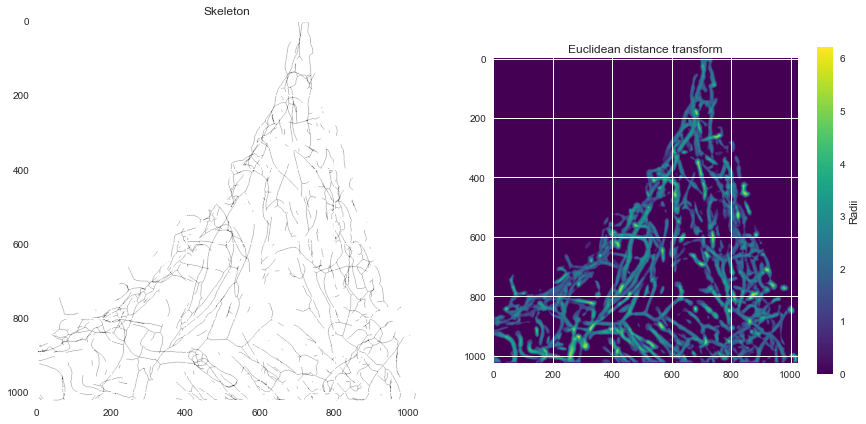

In [278]:
proj_skeleton = itk.maximum_projection_image_filter(skeleton_itk)
#print(proj_skeleton)
np_view_skeleton = itk.array_view_from_image(proj_skeleton)
# print(np_view_skeleton)
proj_dm = itk.maximum_projection_image_filter(dm_itk)
np_view_dm = (itk.array_view_from_image(proj_dm))*0.65
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('Skeleton')
plt.imshow(np_view_skeleton[0])
plt.subplot(1,2,2)
plt.imshow(np_view_dm[0], cmap="viridis")
plt.title('Euclidean distance transform')
plt.colorbar(shrink=0.4, label="Radii", orientation="vertical")
# plt.clim(0, 46.40)
plt.show()

In [280]:
#Transform Euclidean distance transform into an array

scale = 0.65 #dimensions of x and y in µm (see on Fiji, Image > Properties...)

array_dm = (itk.array_view_from_image(dm_itk))*scale

print('Maximal distance computed:', array_dm.max())
view(array_dm)

Maximal distance computed: 6.200605


Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [281]:
#Computation of the radius

print(array_dm.max())
radius = np.zeros((slices, height, width))
array_skeleton = itk.array_view_from_image(skeleton_itk)
print(array_skeleton.shape)
for y in range(height):
    for x in range(width):
        for z in range(slices):
            skeleton = array_skeleton[z,y,x]
            if skeleton != 0:
                radius[z,y,x] = array_dm[z,y,x]                              

6.200605
(75, 1024, 1024)


In [282]:
view(radius)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [283]:
print('Maximal distance computed:', array_dm.max())
print('Maximal radius computed:', radius.max())
print(radius.shape)

Maximal distance computed: 6.200605
Maximal radius computed: 5.886000633239746
(75, 1024, 1024)


In [231]:
# diam_255 = diam*(255/array_dm.max())
# print(diam.shape)
# view(diam)

In [285]:
#Generate a list of the whole radii computed in an excel file

radius_list = []
for y in range(height):
    for x in range(width):
        for z in range(slices):
            if radius[z,y,x] != 0:
                radius_list.append(radius[z,y,x])
radius_array = np.array(radius_list)
print(radius_array.shape)

df = pd.DataFrame(radius_array)
df.to_excel(excel_writer = r"E:\Cecile\results\Stade 2\P18-5A cornedroite\radius.xlsx") #Choose a path for the *.xlsx file

(24623,)


In [240]:
# diam_list_µm = []
# for i in range(len(diam_list)):
#     diam_list_µm.append(diam_list[i]/1.4482)
    
# print(len(diam_list_µm), max(diam_list_µm))

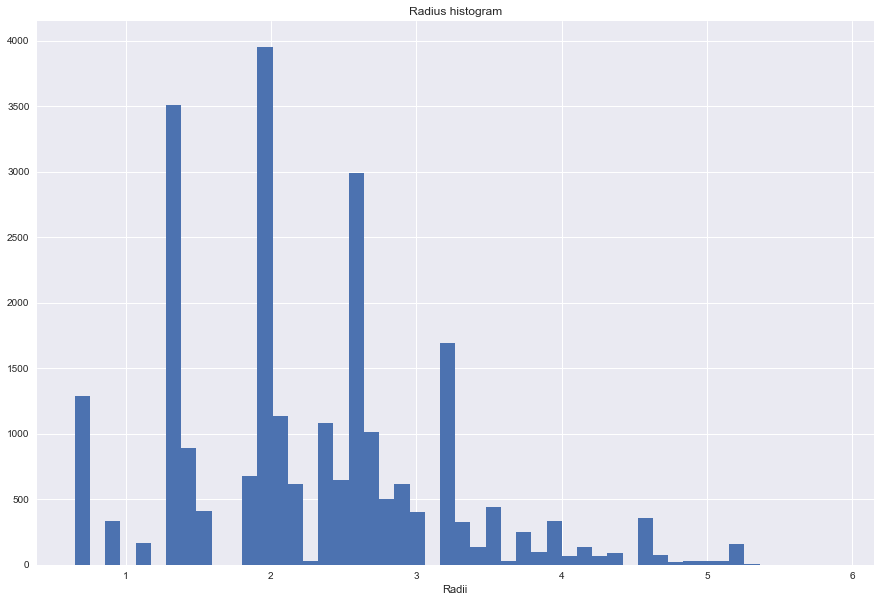

24623


In [286]:
#Histogramme des diamètres
plt.figure(figsize=(15,10))
plt.hist(radius_list, 50)
plt.title('Radius histogram')
plt.xlabel("Radii")
plt.show()

print(len(radius_list))

In [287]:
# def otsu_threshold(h):
#     h = h*1/h.sum() # Probability histogram
    
#     # Check every possible threshold
#     var_within = np.zeros(len(h))
#     var_between = np.zeros(len(h))
#     sep = np.zeros(len(h))
    
#     for t in range(1,len(h)-1):
#         # Class probabilities
#         w1 = h[:t].sum()
#         w2 = h[t:].sum()
#         # Class means
#         m1 = (np.arange(0,t)*h[:t]).sum()/w1
#         m2 = (np.arange(t,len(h))*h[t:]).sum()/w2
#         # Class variances
#         s1 = (((np.arange(0,t)-m1)**2)*h[:t]).sum()/w1
#         s2 = (((np.arange(t,len(h))-m2)**2)*h[t:]).sum()/w2
#         # Intra-class
#         sw = w1*s1+w2*s2
#         # Inter-class
#         sb = w1*w2*((m2-m1)**2)
#         # Separability
#         var_within[t] = sw
#         var_between[t] = sb
    
#     sep[1:-1] = var_between[1:-1]/var_within[1:-1] #compute all values directly
#     best_t = np.argmax(sep)
    
#     return best_t, var_within, var_between, sep

# diam_array_µm = np.array(np_view_diam[0])
# print(diam_array_µm.shape)

# h = np.histogram(diam_array_µm.flatten(), range(257))
# print(h.shape)
# plt.hist(h)
# plt.show()

# t, vw,vb,sep = otsu_threshold(h)
# print("Otsu threshold:", t)

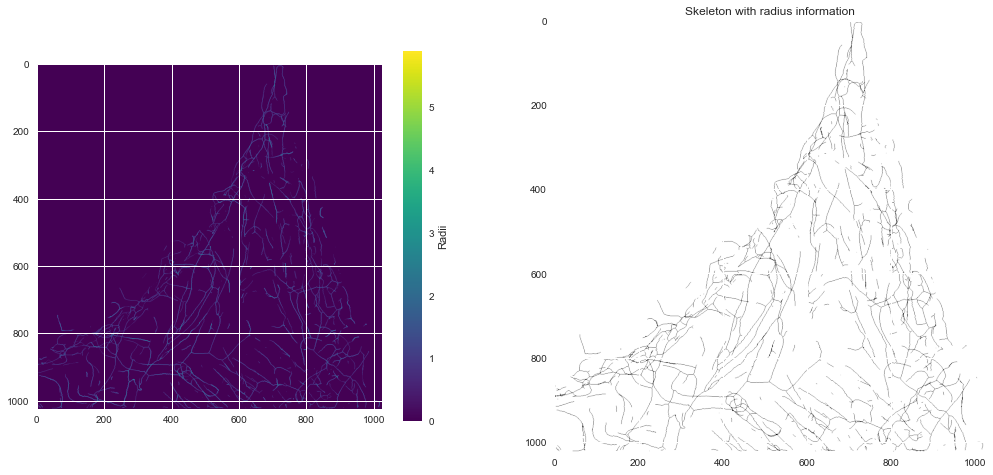

In [289]:
radius_itk = itk.image_from_array(radius)
#diam_255_itk = itk.image_from_array(diam_255)
proj_radius = itk.maximum_projection_image_filter(radius_itk)

np_view_radius = itk.array_view_from_image(proj_radius)
#np_view_diam_255 = itk.array_view_from_image(diam_255_itk)

plt.figure(figsize=(17,17))
plt.subplot(1,2,1)
plt.imshow(np_view_radius[0], cmap='viridis')
plt.colorbar(shrink=0.4, label="Radii", orientation="vertical")
plt.subplot(1,2,2)
plt.imshow(np_view_skeleton[0])
plt.title('Skeleton with radius information')
plt.show()

In [241]:
# count_diam = 0
# for y in range(height):
#     for x in range(width):
#             diam_intensity = diam[y,x]
#             if diam_intensity != 0:
#                 count_diam = count_diam +1
# print(count_diam)

In [290]:
#List of the coordinates of the skeleton

radius_only = []
for y in range(height):
    for x in range(width):
        for z in range(slices):
            if radius[z,y,x] != 0:
                radius_only.append([z,y,x])

#print(diam_only)
#print(diam[14,3,11])
print(len(radius_only))
# print(diam_only[2][0])

24623


In [246]:
#Estimer la localisation de la carie en un point

import math

carie_x = 2048
carie_y = 1235
carie_z = 154 

dist=[None]*len(radius_only)
radii=[None]*len(radius_only)

for k in range(len(radius_only)):
    dist[k]= math.sqrt((radius_only[k][0] - carie_z)**2+(radius_only[k][1] - carie_y)**2+(radius_only[k][2] - carie_x)**2)
    radii[k] = radius[radius_only[k][0], radius_only[k][1], radius_only[k][2]]
#print(dist, diameters)


In [247]:
#Sorted array of distance and radius information

array_plot_total = []
#print(array_plot)
# for k in range(len(dist_cap)):
for k in range(len(dist)):
    array_plot_total.append([dist[k],radii[k]])
#     array_plot[k][0] = dist_cap[k]
#     print(k, dist_cap[k], array_plot[k][0])
#     array_plot[k][1] = diameters_cap[k]
#     print(k, diameters_cap[k], array_plot[k][1])
print(array_plot_total, len(array_plot_total), max(array_plot_total), min(array_plot_total)) 
array_plot_total.sort()
print("Sorted:",array_plot_total)

[[2168.6076178045673, 1.0], [2001.6755481346122, 8.0], [2001.9797701275604, 8.0], [2001.4647136534784, 9.0], [2000.9272850356156, 9.0], [2000.1074971110927, 10.0], [2001.2336195457042, 9.0], [2000.437202213556, 11.0], [2001.5641383677917, 10.0], [1999.9247485843061, 10.770329475402832], [2002.6934363501568, 9.0], [2001.8723735543183, 10.0], [2000.3079762876516, 9.165151596069336], [2000.2822300865446, 10.049875259399414], [1999.4131639058496, 10.440306663513184], [2003.0029955045, 9.0], [1999.8524945605363, 7.280109882354736], [1998.9812405322868, 7.4833149909973145], [1998.9544767202678, 8.306623458862305], [2003.336716580615, 9.899495124816895], [2000.2462348421006, 5.656854152679443], [1999.3731517653227, 6.0], [1999.3448927086092, 6.7082037925720215], [2004.4478042593178, 8.0], [2003.6249649073552, 9.0], [1999.8314929013395, 5.099019527435303], [1999.8007400738704, 5.196152210235596], [1999.7704868309263, 5.099019527435303], [1999.740733195181, 5.0], [2004.760584209496, 8.0], [1999

In [248]:
dist_sorted = []
radius_sorted = []

for k in range(len(array_plot_total)):
    dist_sorted.append(array_plot_total[k][0])
    radius_sorted.append(array_plot_total[k][1])
#print("dist", dist_sorted, "diam", diam_sorted)

In [249]:
print(len(dist), len(radii))
print(max(radii))

15278 15278
14.071247100830078


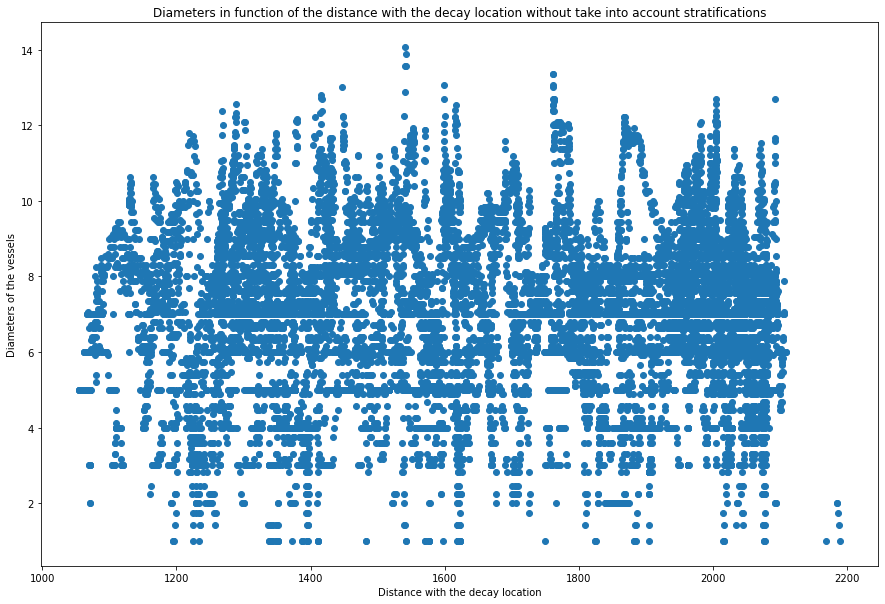

In [250]:
plt.figure(figsize=(15,10))
plt.scatter(dist_sorted, radius_sorted)
plt.title("Radii in function of the distance with the decay location without take into account stratifications")
plt.xlabel("Distance with the decay location")
plt.ylabel("Radii of the vessels")
plt.show()

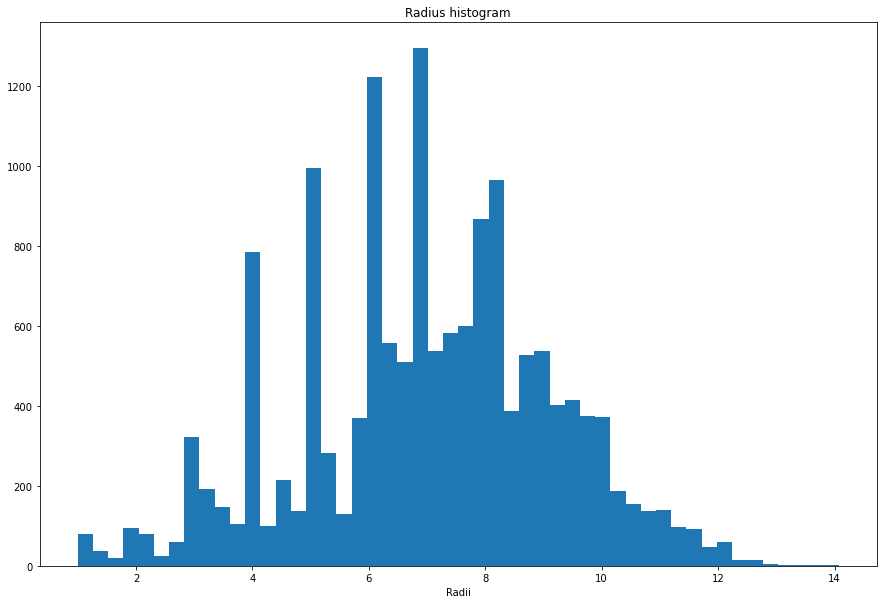

In [252]:
#Histogramme des rayons

plt.figure(figsize=(15,10))
plt.hist(radii, 50)
plt.title('Radius histogram')
plt.xlabel("Radii")
plt.show()

In [253]:
#Définir les trois types de vaisseaux à partir de leur diamètre

cap = np.zeros((slices, height, width)) 
inter = np.zeros((slices, height, width)) 
big = np.zeros((slices, height, width)) 

for k in range(len(radius_only)):
    intensity = radius[radius_only[k][0], radius_only[k][1], radius_only[k][2]]
    if intensity < 5.2:
        cap[radius_only[k][0], radius_only[k][1], radius_only[k][2]] = intensity
    elif intensity < 17 and intensity >= 0:
        inter[radius_only[k][0], radius_only[k][1], radius_only[k][2]] = intensity
    else :
        big[radius_only[k][0], radius_only[k][1], radius_only[k][2]] = intensity
print("cap: ",cap.max(), cap.min(), "inter: ", inter.max(), inter.min(), "big: ", big.max(), big.min())
        
    

cap:  5.196152210235596 0.0 inter:  14.071247100830078 0.0 big:  0.0 0.0


In [291]:
#Only capillaries of the skeleton
view(cap)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [20]:
#Only intermediaite vessels of the skeleton

view(inter)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [21]:
#Only big vessels of the skeleton

view(big)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [256]:
#Generate array for each type of vessel with the coordinates of the skeleton

radius_cap = []
for y in range(height):
    for x in range(width):
        for z in range(slices):
            if cap[z,y,x] != 0:
                radius_cap.append([z,y,x])
radius_inter = []
for y in range(height):
    for x in range(width):
        for z in range(slices):        
            if inter[z,y,x] != 0:
                radius_inter.append([z,y,x])
radius_big = []
for y in range(height):
    for x in range(width):
        for z in range(slices):        
            if big[z,y,x] != 0:
                radius_big.append([z,y,x])

#print(diam_only)
#print(diam[14,3,11])
print(len(radius_cap), len(radius_inter), len(radius_big))

3452 11826 0


In [258]:
#Generate array for each type of vessel with the radius information

cap_list = []
for y in range(height):
    for x in range(width):
        for z in range(slices):
            if cap[z,y,x] != 0:
                cap_list.append(cap[z,y,x])
            
inter_list = []
for y in range(height):
    for x in range(width):
        for z in range(slices):
            if inter[z,y,x] != 0:
                inter_list.append(inter[z,y,x])
                
big_list = []
for y in range(height):
    for x in range(width):
        for z in range(slices):
            if big[z,y,x] != 0:
                big_list.append(big[z,y,x])

In [259]:
print(len(cap_list), len(inter_list))

3452 11826


In [86]:
#print(diam_big)

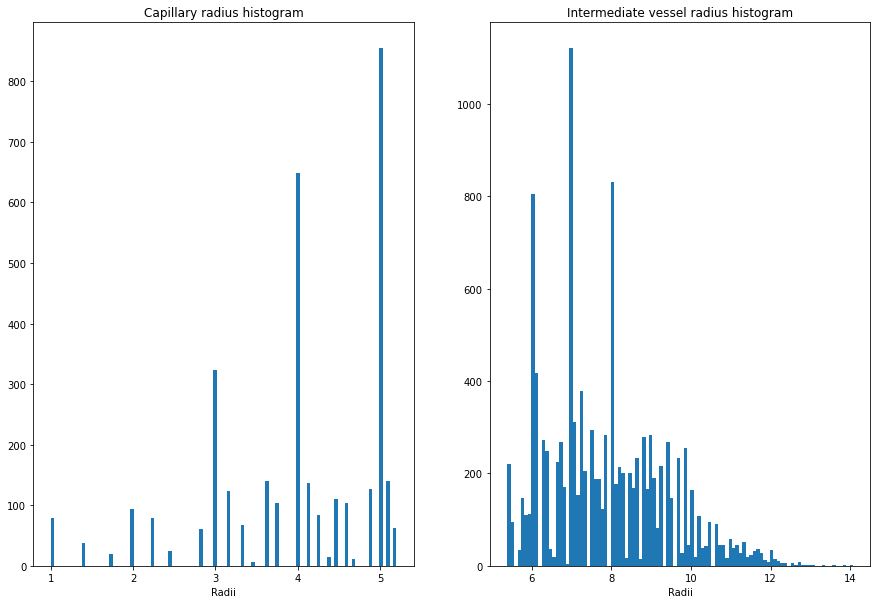

In [260]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.hist(cap_list, 100)
plt.title('Capillary radius histogram')
plt.xlabel("Radii")
plt.subplot(1,2,2)
plt.hist(inter_list, 100)
plt.title('Intermediate vessel radius histogram')
plt.xlabel("Radii")
plt.show()

In [255]:
# diam_itk_UC = itk.imread(diam_itk, itk.UC)
# print(diam_itk_UC)
# # itk.imwrite(skeleton_itk,  r"E:\Cecile\results\saine\Dent4_P09A_large image\diam_big.tif")

In [262]:
#Estimer la localisation de la carie en un point

import math

carie_x = 894
carie_y = 130
carie_z = 213 

dist_cap=[None]*len(radius_cap)
radii_cap=[None]*len(radius_cap)

for k in range(len(radius_cap)):
    dist_cap[k]= math.sqrt((radius_cap[k][0] - carie_z)**2+(radius_cap[k][1] - carie_y)**2+(radius_cap[k][2] - carie_x)**2)
    radii_cap[k] = radius[radius_cap[k][0], radius_cap[k][1], radius_cap[k][2]]
#print(dist, diameters)

dist_inter=[None]*len(radius_inter)
radii_inter=[None]*len(radius_inter)

for k in range(len(radius_inter)):
    dist_inter[k]= math.sqrt((radius_inter[k][0] - carie_y)**2+(radius_inter[k][1] - carie_x)**2+(radius_inter[k][2] - carie_x)**2)
    radii_inter[k] = radius[radius_inter[k][0], radius_inter[k][1], radius_inter[k][2]]
    
dist_big=[None]*len(radius_big)
radii_big=[None]*len(radius_big)

for k in range(len(radius_big)):
    dist_big[k]= math.sqrt((radius_big[k][0] - carie_y)**2+(radius_big[k][1] - carie_x)**2+(radius_big[k][2] - carie_x)**2)
    radii_big[k] = radius[radius_big[k][0], radius_big[k][1], radius_big[k][2]]
    #print(dist_big)

In [263]:
array_plot_cap = []
#print(array_plot)
# for k in range(len(dist_cap)):
for k in range(len(dist_cap)):
    array_plot_cap.append([dist_cap[k],radii_cap[k]])
#     array_plot[k][0] = dist_cap[k]
#     print(k, dist_cap[k], array_plot[k][0])
#     array_plot[k][1] = diameters_cap[k]
#     print(k, diameters_cap[k], array_plot[k][1])
#print(array_plot_cap, len(array_plot_cap), max(array_plot_cap), min(array_plot_cap)) 
array_plot_cap.sort()
#print("Sorted:",array_plot_cap)

array_plot_inter = []
for k in range(len(dist_inter)):
    array_plot_inter.append([dist_inter[k],radii_inter[k]])
print(array_plot_inter, len(array_plot_inter), max(array_plot_inter), min(array_plot_inter)) 
array_plot_inter.sort()
print("Inter sorted:",array_plot_inter)

array_plot_big = []
for k in range(len(dist_big)):
    array_plot_big.append([dist_big[k],radii_big[k]])
print(array_plot_big, len(array_plot_big), max(array_plot_big), min(array_plot_big)) 
array_plot_big.sort()
print("Big sorted:",array_plot_big)

[[909.1941486833272, 8.0], [908.9697464712453, 8.0], [908.1839020815113, 9.0], [907.37478474994, 9.0], [906.8125495382163, 10.0], [907.1543418845549, 9.0], [906.6167878436843, 11.0], [906.9608591334028, 10.0], [905.8355259096433, 10.770329475402832], [907.3114129117962, 9.0], [906.7447270318146, 10.0], [905.7046980114435, 9.165151596069336], [905.6743344050333, 10.049875259399414], [905.0557993847672, 10.440306663513184], [907.0986715898111, 9.0], [904.9955800997042, 7.280109882354736], [904.3721579084576, 7.4833149909973145], [904.3395380054993, 8.306623458862305], [906.9128954866613, 9.899495124816895], [904.8878383534613, 5.656854152679443], [904.2599183863011, 6.0], [904.2239766783449, 6.7082037925720215], [907.2518944593062, 8.0], [906.6796567696884, 9.0], [907.0468565625482, 8.0], [903.4793854870181, 5.385164737701416], [906.8213716052352, 7.0], [903.9961283102931, 7.0], [903.9502198683288, 6.164413928985596], [903.3116848574472, 5.74456262588501], [907.8221191400879, 7.0], [907.

ValueError: max() arg is an empty sequence

In [264]:
dist_cap_sorted = []
radius_cap_sorted = []

for k in range(len(array_plot_cap)):
    dist_cap_sorted.append(array_plot_cap[k][0])
    radius_cap_sorted.append(array_plot_cap[k][1])
print("dist", dist_cap_sorted, "diam", radius_cap_sorted, "longueur dist", len(dist_cap_sorted), "longueur diam", len(radius_cap_sorted))

dist_inter_sorted = []
radius_inter_sorted = []

for k in range(len(array_plot_inter)):
    dist_inter_sorted.append(array_plot_inter[k][0])
    radius_inter_sorted.append(array_plot_inter[k][1])
print("dist", dist_inter_sorted, "diam", radius_inter_sorted)

dist_big_sorted = []
radius_big_sorted = []

for k in range(len(array_plot_big)):
    dist_big_sorted.append(array_plot_big[k][0])
    radius_big_sorted.append(array_plot_big[k][1])
print("dist", dist_big_sorted, "diam", radius_big_sorted)

dist [168.64163187066237, 168.67127793433, 169.26015479137433, 169.30741271426953, 169.36646657470303, 169.97058569058353, 170.57842770995398, 171.1899529762188, 171.27755252805312, 171.89822570346675, 172.52246230563716, 173.1502237942533, 173.78147196982766, 173.90227140552247, 174.03447934245673, 175.7583568425695, 176.90958142508845, 177.5556250869006, 178.20493820318222, 178.85748516626302, 179.51323071016242, 180.17213991069764, 180.83417818543043, 181.4993112934592, 182.16750533506243, 182.83872675120006, 183.02458851203573, 183.64367672206959, 184.32579851990334, 184.52642087245934, 185.21609001379983, 185.9085796836714, 186.60385848100785, 186.82879863661276, 187.0641601162553, 198.66051444612742, 198.73852168112754, 199.95249435803495, 200.74610830598934, 201.60853156550692, 202.41047403728888, 203.21909359112888, 204.03431084011336, 204.36486977951958, 205.2364490045567, 206.06794995826013, 206.9057756564567, 207.74984957876623, 208.60009587725506, 209.45643938537674, 210.31

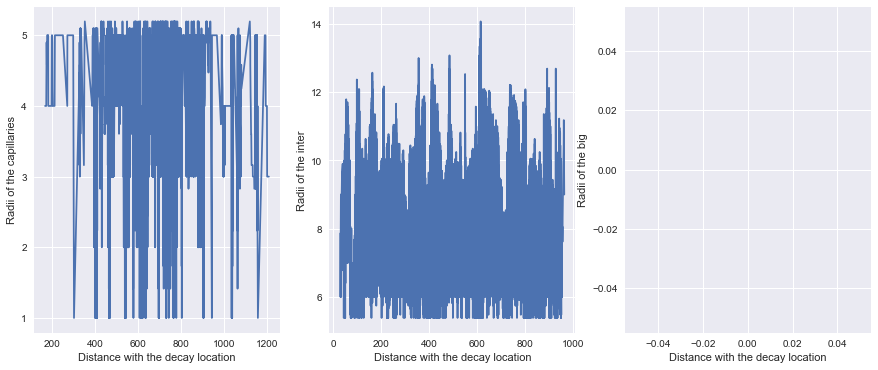

In [265]:
plt.style.use('seaborn')
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
# plt.plot(dist_cap_sorted, diam_cap_sorted, color = 'black',linestyle = 'dashed')
plt.plot(dist_cap_sorted, radius_cap_sorted)
#plt.title("Diameters of capillaries in function of the distance with the decay location without take into account stratifications")
plt.xlabel("Distance with the decay location")
plt.ylabel("Radii of the capillaries")
plt.subplot(1,3,2)
plt.plot(dist_inter_sorted, radius_inter_sorted)
#plt.title("Diameters of capillaries in function of the distance with the decay location without take into account stratifications")
plt.xlabel("Distance with the decay location")
plt.ylabel("Radii of the inter")
plt.subplot(1,3,3)
plt.plot(dist_big_sorted, radius_big_sorted)
#plt.title("Diameters of capillaries in function of the distance with the decay location without take into account stratifications")
plt.xlabel("Distance with the decay location")
plt.ylabel("Radii of the big")
plt.show()

In [244]:
# np_view_diam = itk.array_view_from_image(diam_itk)
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.imshow(diam_255)
# plt.subplot(1,2,2)
# plt.imshow(np_view_skeleton)
# plt.show()